# Declarations

## Imports

In [1]:
import re
import os
import math
import string
import random
import requests
import importlib
import itertools

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import numpy as np
import pandas as pd

import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import plotly.graph_objects as go

from tqdm import tqdm

from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

tfk = tf.keras
tfkl = tf.keras.layers
kb = tf.keras.backend

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.13.0
Num GPUs Available:  1


## Constants

In [4]:
# Randomness
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [5]:
# Filepaths
kaggle = False

model_versions = ["v4.0"]

github_repo = "raul-singh/Rise-of-Transformers-Project"
github_branch = "main"
github_python_prefix = ["Code", "Notebooks", "py_files"]
github_clip_models_prefix = ["Code", "Models"] if kaggle else ["..", "Models"]
github_pyfiles_data = [
    {"name": "preprocessing", "imports": ["import_datasets", "load_image_from_path"]},
    {"name": "evaluation", "imports": [
        "EvalMetrics as evm", "compute_total_relevance", "generate_image_embeddings", "generate_text_embeddings", 
        "index_to_reference", "compute_relevant_at_k", "decode_concepts"
    ]}, 
    {"name": "clip", "imports": ["build_clip"]}
]
github_pyfiles = ["/".join(github_python_prefix) + "/" + pf["name"] + ".py" for pf in github_pyfiles_data]
github_clip_models = [f"{'/'.join(github_clip_models_prefix)}/{version}.yaml" for version in model_versions]

kaggle_dataset1 = "/kaggle/input/transformers-hackathon/"
kaggle_dataset2 = "/kaggle/input/transformers-hackathon-features/"
kaggle_weights = "/kaggle/input/clip-weights/"
kaggle_relevance = "/kaggle/input/clip-relevance/"

image_dir = "./resized_train"
relevance_dir = "./relevance"
caption_pred_file = "caption_prediction_train.csv"
concept_det_file = "concept_detection_train.csv"
concept_file = "concepts.csv"
classification_file = "classification.csv"
clip_weights_files = [f"{version}.h5" for version in model_versions] if kaggle else [None for _ in model_versions]

if kaggle:
    image_dir = kaggle_dataset1 + image_dir
    relevance_dir = kaggle_relevance + relevance_dir
    caption_pred_file = kaggle_dataset2 + caption_pred_file
    concept_det_file = kaggle_dataset2 + concept_det_file
    concept_file = kaggle_dataset2 + concept_file
    classification_file = kaggle_dataset2 + classification_file
    clip_weights_files = [kaggle_weights + weight for weight in clip_weights_files]

In [6]:
# Train/Val/Test split and filter percentages
test_size = 0.2
val_size = 0
filter_percent_dataset = 1

# Batch size
batch_size = 32

# Import dataset types and shapes
in_feat_typ = {'caption': tf.string, 'concepts': tf.bool, 'image path': tf.string}
feature_shapes = {'image': (128, 128, 3), 'caption': (), 'concepts': (8374)}

# Output dataset structure
x_features_eval = ['image path', 'image']
y_features_eval = ['caption', 'concepts']

# Define parameters for dataset import
dataset_parameters = [{
    'x_features': x_features_eval, 'y_features': y_features_eval,
    'x_dict': True, 'y_dict': True,           
    'shuffle_buffer_size': 1,
    'batch_size': batch_size,
    'cached': True,
}]

# Classification labels
classification_labels = ['angiography', 'echocardiography', 'ultrasound', 'tomography', 'xray']

## Meta-Imports

In [7]:
def clean_recursive_imports(source, import_list, prefix):
    import_prefix = re.sub(r"/", ".", prefix)
    for target_import in import_list:
        source = re.sub(r"from[ \t]+" + re.escape(target_import) + r"[ \t]+import", f"from {import_prefix + target_import} import", source)
    return source
    
def import_py_from_repo(repository, branch, filepath, prefix, recursive_imports_list=None):
    # Build path for retrieval and write name
    path_pre = "https://raw.githubusercontent.com/"
    path = path_pre + repository + "/" + branch + "/" + filepath 
    write_path = prefix + filepath.split("/")[-1]
    print("Downloading file from " + path)
    # Obtain raw text from file
    text = requests.get(path).text
    # Clean recursive imports
    text = clean_recursive_imports(text, recursive_imports_list, prefix) if recursive_imports_list else text
    # Create subdirectories if not exist
    os.makedirs(os.path.dirname(write_path), exist_ok=True)
    # Write file
    f = open(write_path, "w")
    f.write(text)
    f.close()

In [8]:
if kaggle:
    for pf_data, py_file in zip(github_pyfiles_data, github_pyfiles):
        import_py_from_repo(
            github_repo, github_branch, py_file, 
            "/".join(github_python_prefix) + "/", 
            recursive_imports_list=[pf["name"] for pf in github_pyfiles_data],
        )
        import_string = f'from {".".join(github_python_prefix) + "." + pf_data["name"]} import {", ".join(pf_data["imports"])}'
        exec(import_string)
    
    for model in github_clip_models:
        import_py_from_repo(github_repo, github_branch, model, "/".join(github_clip_models_prefix) + "/")
        
else:
    for pf_data in github_pyfiles_data:
        import_string = f'from py_files.{pf_data["name"]} import {", ".join(pf_data["imports"])}'
        exec(import_string)

# Preprocessing

In [9]:
# Import custom classification dataset
df = pd.read_csv(classification_file)
dataset = tf.data.Dataset.from_tensor_slices(dict(df))
dataset = dataset.map(lambda x: {'image': load_image_from_path(image_dir + "/" + x['image path']), 'label': x['label']})
dataset = dataset.batch(batch_size)

In [10]:
# Preprocess classification labels
labels_dataset = tf.data.Dataset.from_tensor_slices({'label': classification_labels}).batch(batch_size)

# Model Import

In [11]:
models = []
for structure, weights in zip(github_clip_models, clip_weights_files):
    print(f"Creating model {structure}")
    clip_image_encoder, clip_text_encoder, clip = build_clip(structure, weights_path=weights)
    models.append({
        "image_encoder": clip_image_encoder,
        "clip_text_encoder": clip_text_encoder,
        "clip": clip,
    })

Creating model Code/Models/v4.0.yaml
82420632/82420632 [==============================] - 1s 0us/step
Models downloaded.
Building clip...
Loading parameters...
Done.


In [12]:
# Select the loaded model to evaluate
clip_image_encoder, clip_text_encoder, clip = models[0].values()

del models

# Model Evaluation

## Evaluation Definitions

### Evaluation Variables

In [13]:
# Visualization decimal precision
decimal_precision = 4
# Function to preprocess data when we want to evaluate captions
reference_preprocess_cap = lambda x: x["caption"].numpy().decode('UTF-8')          
# Function to preprocess data when we want to evaluate concepts
reference_preprocess_con = lambda x: x["concepts"].numpy()
reference_preprocess_con_hash = lambda x: frozenset(sorted(np.where(x["concepts"].numpy())[0]))

### Evaluation Functions

In [14]:
def zeroshot_classifier(image_embeddings, class_embeddings, normalize=True):
    if normalize:
        image_embeddings = tf.math.l2_normalize(image_embeddings, axis=1)
        class_embeddings = tf.math.l2_normalize(class_embeddings, axis=1)
    similarities = tf.matmul(image_embeddings, class_embeddings, transpose_b=True)
    return tf.nn.softmax(similarities, axis=1)

## Dataset Metrics

In [15]:
# Generating embeddings for image-to-text and text-to-image tasks
reference, image_embeddings = generate_image_embeddings(
    clip_image_encoder,
    dataset,
    dataset_pred_map=lambda x: x['image'],
    dataset_ref_map=lambda x: x['label'],
)

_, text_embeddings = generate_text_embeddings(
    clip_text_encoder,
    labels_dataset,
    dataset_pred_map=lambda x: x["label"],
    dataset_ref_map=lambda x: x,
)

reference = [e.numpy().decode('UTF8') for e in reference]

Generating image embeddings
129/129 [==============================] - 11s 59ms/step
Generating text embeddings
1/1 [==============================] - 0s 425ms/step


## Zero-Shot Classification Task

In [16]:
zeroshot_results = zeroshot_classifier(image_embeddings, text_embeddings)

In [17]:
print("\n### Scoring classification dataset ###")

n = len(zeroshot_results)
t = 0

for ref, result in zip(reference, zeroshot_results):
    idx = np.argmax(result)
    confidence = np.max(result)
    label = classification_labels[idx]
    if label == ref:
        t += 1
print(f"Accuracy: {t/n*100:.3f}%")


### Scoring classification dataset ###
Accuracy: 93.627%


## Playground

In [18]:
def zero_shot_complete(images, classes, batch_size=32):
    reference, image_embeddings = generate_image_embeddings(
        clip_image_encoder,
        dataset,
        dataset_pred_map=lambda x: x['image'],
        dataset_ref_map=lambda x: x['label'],
    )
    _, text_embeddings = generate_text_embeddings(
        clip_text_encoder,
        classes,
        dataset_pred_map=lambda x: x["label"],
        dataset_ref_map=lambda x: x,
    )
    return zeroshot_classifier(image_embeddings, text_embeddings), reference

In [19]:
images = dataset.unbatch().skip(4).take(4).batch(batch_size)

zeroshot_results, info = zero_shot_complete(images, labels_dataset)

Generating image embeddings
129/129 [==============================] - 4s 29ms/step
Generating text embeddings
1/1 [==============================] - 0s 17ms/step



### Scoring classification data ###


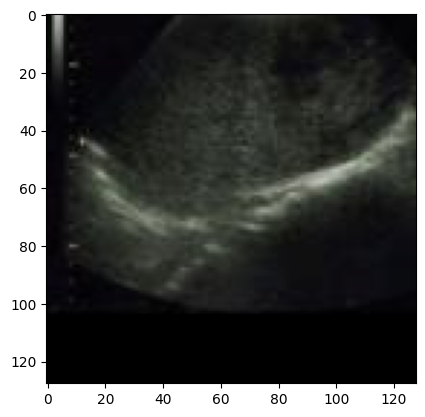

Classes:	['angiography', 'echocardiography', 'ultrasound', 'tomography', 'xray']
Prediction:	This is a photo of a echocardiography, confidence 24.076%
Actual classes:	ultrasound
Wrong Prediction
#########################################################


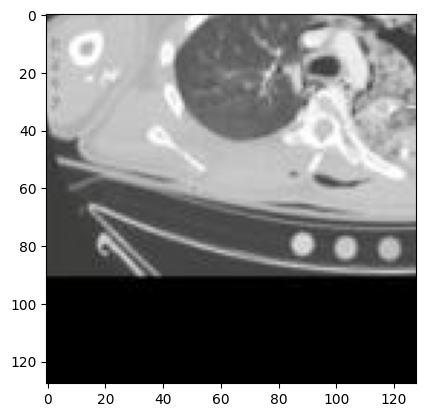

Classes:	['angiography', 'echocardiography', 'ultrasound', 'tomography', 'xray']
Prediction:	This is a photo of a ultrasound, confidence 28.364%
Actual classes:	ultrasound
Right Prediction
#########################################################


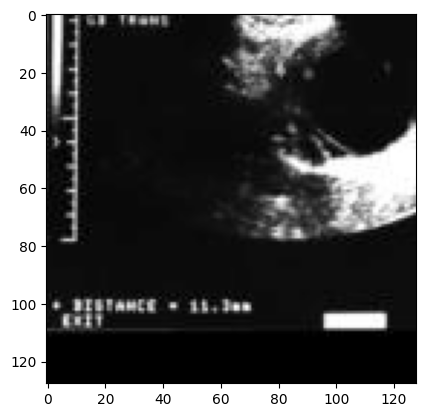

Classes:	['angiography', 'echocardiography', 'ultrasound', 'tomography', 'xray']
Prediction:	This is a photo of a tomography, confidence 30.027%
Actual classes:	tomography
Right Prediction
#########################################################


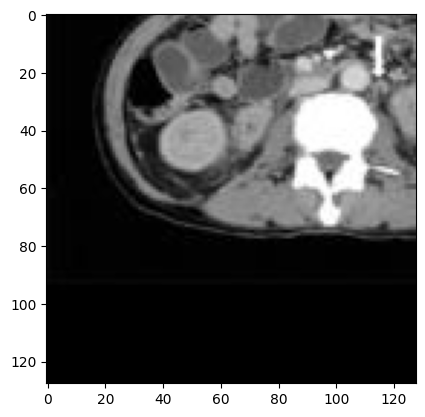

Classes:	['angiography', 'echocardiography', 'ultrasound', 'tomography', 'xray']
Prediction:	This is a photo of a xray, confidence 25.201%
Actual classes:	xray
Right Prediction
#########################################################
Accuracy: 75.000%


In [20]:
print("\n### Scoring classification data ###")

n = 0
t = 0 

for element, element_ref, result in zip(images.unbatch(), info, zeroshot_results):

    idx = np.argmax(result)
    confidence = np.max(result)

    plt.figure()
    plt.imshow(np.array(element["image"].numpy(), dtype=np.float64))
    plt.show()

    print(f'Classes:\t{classification_labels}')
    print(f'Prediction:\tThis is a photo of a {classification_labels[idx]}, confidence {confidence*100:.3f}%')
    print(f'Actual classes:\t{element_ref.numpy().decode("UTF-8")}')

    n += 1

    # Check if at least one class has been predicted correctly
    if classification_labels[idx] == element_ref:
        t += 1
        print(f'Right Prediction')
    else:
        print(f'Wrong Prediction')

    print(f'#########################################################')

if n != 0:
    print(f"Accuracy: {t/n*100:.3f}%")
else:
    print(f"No possible predictions")